# Epistemic regression

In [25]:
%matplotlib inline

import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm, trange

import seaborn as sns


## Helper functions

In [2]:
def normalize(image):
    """Takes a tensor of 3 dimensions (height, width, colors) and normalizes it's values
    to be between 0 and 1 so it's suitable for displaying as an image."""
    image = image.astype(np.float32)
    return (image - image.min()) / (image.max() - image.min() + 1e-5)


def display_images(images, titles=None, cols=5, interpolation=None, cmap="Greys_r"):
    """
    images: A list of images. I can be either:
        - A list of Numpy arrays. Each array represents an image.
        - A list of lists of Numpy arrays. In this case, the images in
          the inner lists are concatentated to make one image.
    """
    titles = titles or [""] * len(images)
    rows = math.ceil(len(images) / cols)
    height_ratio = 1.2 * (rows/cols) * (0.5 if type(images[0]) is not np.ndarray else 1)
    plt.figure(figsize=(15, 15 * height_ratio), dpi=200)
    i = 1
    for image, title in zip(images, titles):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Is image a list? If so, merge them into one image.
        if type(image) is not np.ndarray:
            image = [normalize(g) for g in image]
            image = np.concatenate(image, axis=1)
        else:
            image = normalize(image)
        plt.title(title, fontsize=12)
        plt.imshow(image, cmap=cmap, interpolation=interpolation)
        i += 1

        
def show(img,cmap='viridis'):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', cmap=cmap)

In [18]:
def uncertainity_estimate_2d(X, model, iters, l2, dropout_p=0.5, decay=1e-6):
    outputs = [model(X).cpu().data for i in range(iters)]
    outputs = torch.stack(outputs)
    y_mean = outputs.mean(dim=0)
    y_variance = outputs.var(dim=0)
    tau = l2 * (1. - dropout_p) / (2. * iters * decay)
    y_variance += (1. / tau)
    y_std = np.sqrt(y_variance)
    return y_mean, y_std


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

In [5]:
BATCH_SIZE = 128
TEST_BATCH_SIZE = 5

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=True, download=True,
        transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        './mnist', train=False, download=True,
        transform=transforms.ToTensor()),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **LOADER_KWARGS)


TRAIN_SIZE = len(train_loader.dataset)
TEST_SIZE = len(test_loader.dataset)
NUM_BATCHES = len(train_loader)
NUM_TEST_BATCHES = len(test_loader)

CLASSES = 10
TRAIN_EPOCHS = 10 #20
SAMPLES = 2
TEST_SAMPLES = 10

In [8]:
class AutoEncoderEpistemic(nn.Module):
    def __init__(self, p=0.5):
        self.dropout_p = p
        super(AutoEncoderEpistemic, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3))
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Dropout(p=self.dropout_p),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Dropout(p=self.dropout_p),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Dropout(p=self.dropout_p),
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
model = AutoEncoderEpistemic(p=0.1).to(DEVICE)

In [13]:
def train_autoencoder(model, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
#     for batch_idx, (data, target) in enumerate(train_loader):
        data = data.view(data.size(0), -1)
        data, target = data.to(DEVICE), target.to(DEVICE)
        model.zero_grad()
        out = model(data)
        loss = criterion(out, data)
        loss.backward()
        optimizer.step()
     
    print('epoch [{}], loss:{:.4f}'.format(epoch, loss.data.item()))


In [14]:
TRAIN_EPOCHS = 5 #20
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(TRAIN_EPOCHS):
    train_autoencoder(model, optimizer, criterion, epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

epoch [0], loss:0.0530


  0%|          | 0/469 [00:00<?, ?it/s]

epoch [1], loss:0.0450


  4%|▍         | 18/469 [00:02<01:00,  7.47it/s]


KeyboardInterrupt: 

tensor([7, 2, 1, 0, 4])


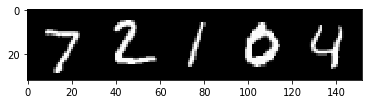

In [15]:
mnist_sample, mnist_target = iter(test_loader).next()
mnist_sample = mnist_sample.to(DEVICE)
print(mnist_target)
# sns.set_style("dark")
show(make_grid(mnist_sample.cpu()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 1, 28, 28])


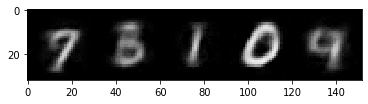

In [16]:
out = model(mnist_sample)
out = out.detach().cpu()
out = out.view(-1, 1, 28,28)
print(out.size())
show(make_grid(out))

(28, 28)


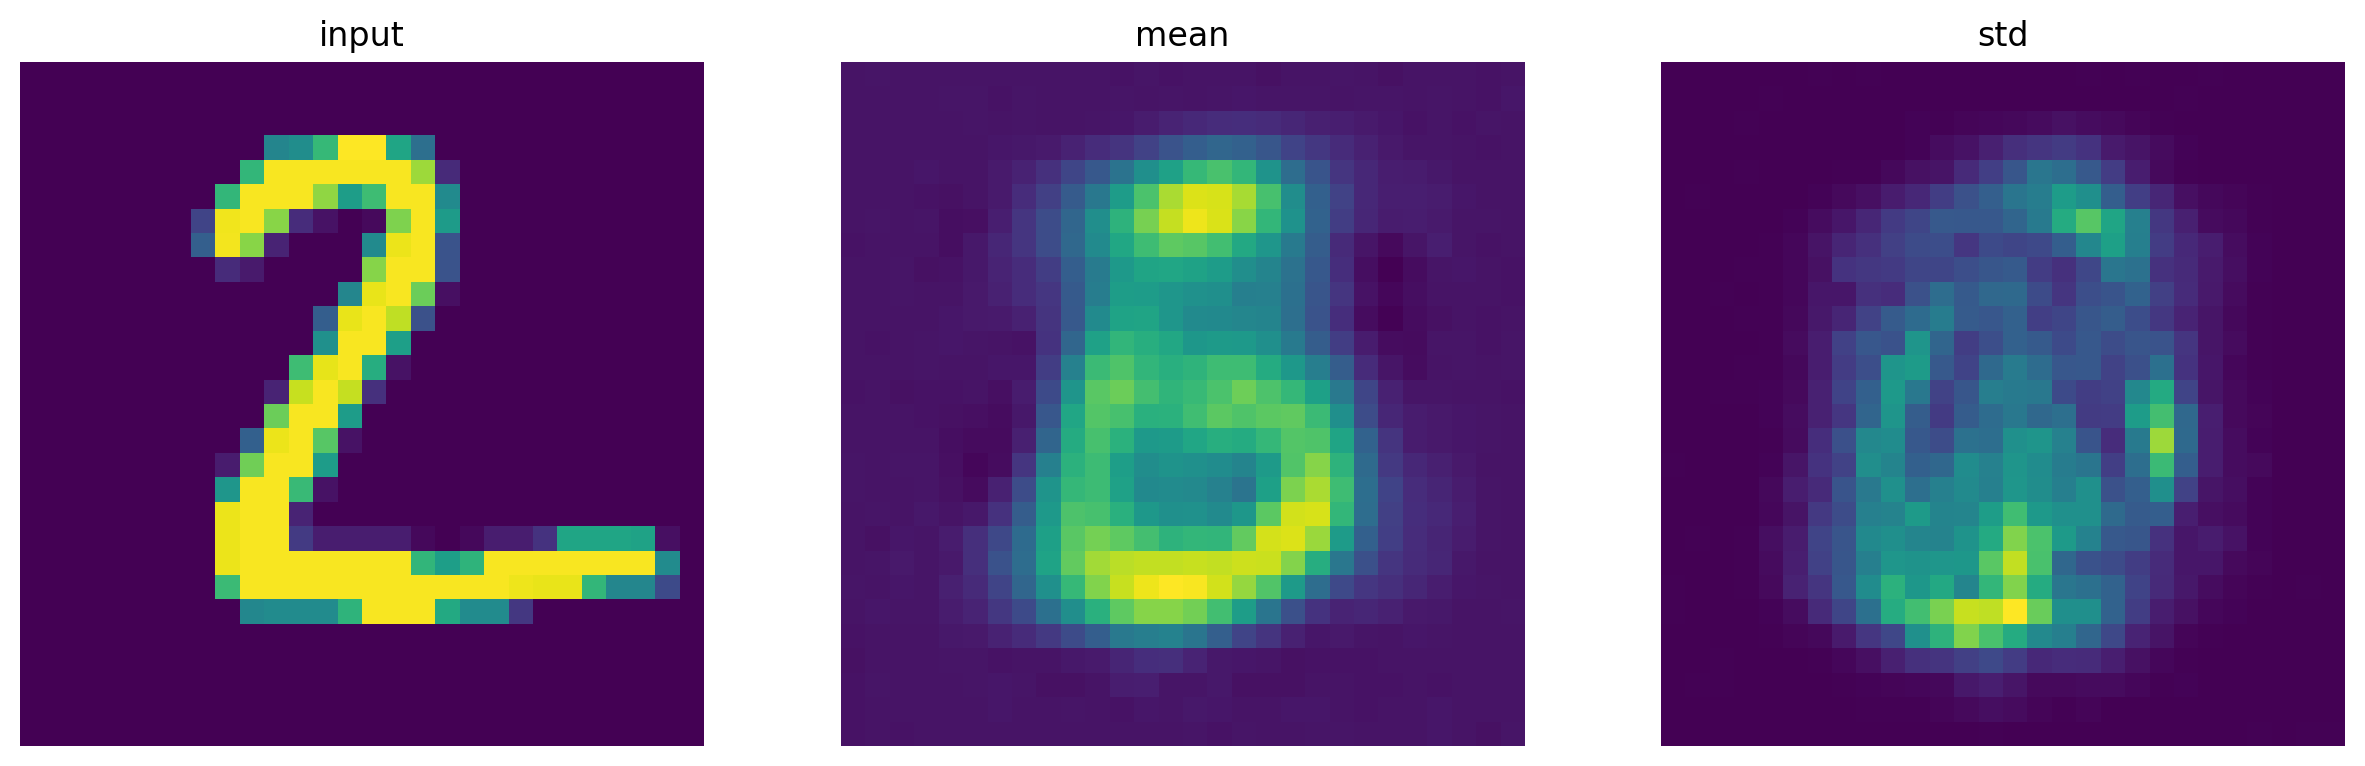

In [19]:
x = mnist_sample[1,:,:,:]
iters = 50
dropout_p=0.1
decay=1e-6
l2 = 0.01

y_mean, y_std = uncertainity_estimate_2d(x, model, iters, l2=l2, dropout_p=dropout_p,decay=decay)

res_list = [x.cpu().view(28,28).numpy(), y_mean.view(28,28).numpy(), y_std.view(28,28).numpy()]
print(res_list[0].shape)
display_images(res_list, titles=['input','mean', 'std'], cols=len(res_list), interpolation=None, cmap="viridis")

## Out of domain samples

In [22]:
kmnist_loader = torch.utils.data.DataLoader(
    datasets.KMNIST('./kmnist', train=False, download=True, transform=transforms.ToTensor()), batch_size=5, shuffle=False)


0it [00:00, ?it/s]


 99%|█████████▉| 18022400/18165135 [00:29<00:00, 637370.60it/s]

Extracting ./kmnist/KMNIST/raw/train-images-idx3-ubyte.gz




0it [00:00, ?it/s]



  0%|          | 0/29497 [00:00<?, ?it/s]

32768it [00:00, 38685.72it/s]            

0it [00:00, ?it/s]

Extracting ./kmnist/KMNIST/raw/train-labels-idx1-ubyte.gz




  0%|          | 0/3041136 [00:06<?, ?it/s]

 40%|███▉      | 1204224/3041136 [00:06<00:00, 12010466.40it/s]

 78%|███████▊  | 2383872/3041136 [00:06<00:00, 11906036.96it/s]

3047424it [00:06, 466399.54it/s]                               
18169856it [00:42, 637370.60it/s]                              

Extracting ./kmnist/KMNIST/raw/t10k-images-idx3-ubyte.gz




0it [00:00, ?it/s]



  0%|          | 0/5120 [00:00<?, ?it/s]

8192it [00:00, 11515.48it/s]            

Extracting ./kmnist/KMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


tensor([2, 9, 3, 8, 3])


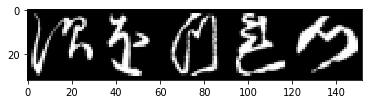

In [31]:
kmnist_sample, kmnist_target = iter(kmnist_loader).next()
kmnist_sample = kmnist_sample.to(DEVICE)
print(kmnist_target)
# sns.set_style("dark")
show(make_grid(kmnist_sample.cpu()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 1, 28, 28])


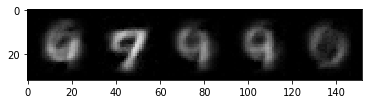

In [32]:
out = model(kmnist_sample)
out = out.detach().cpu()
out = out.view(-1, 1, 28,28)
print(out.size())
show(make_grid(out))

(28, 28)


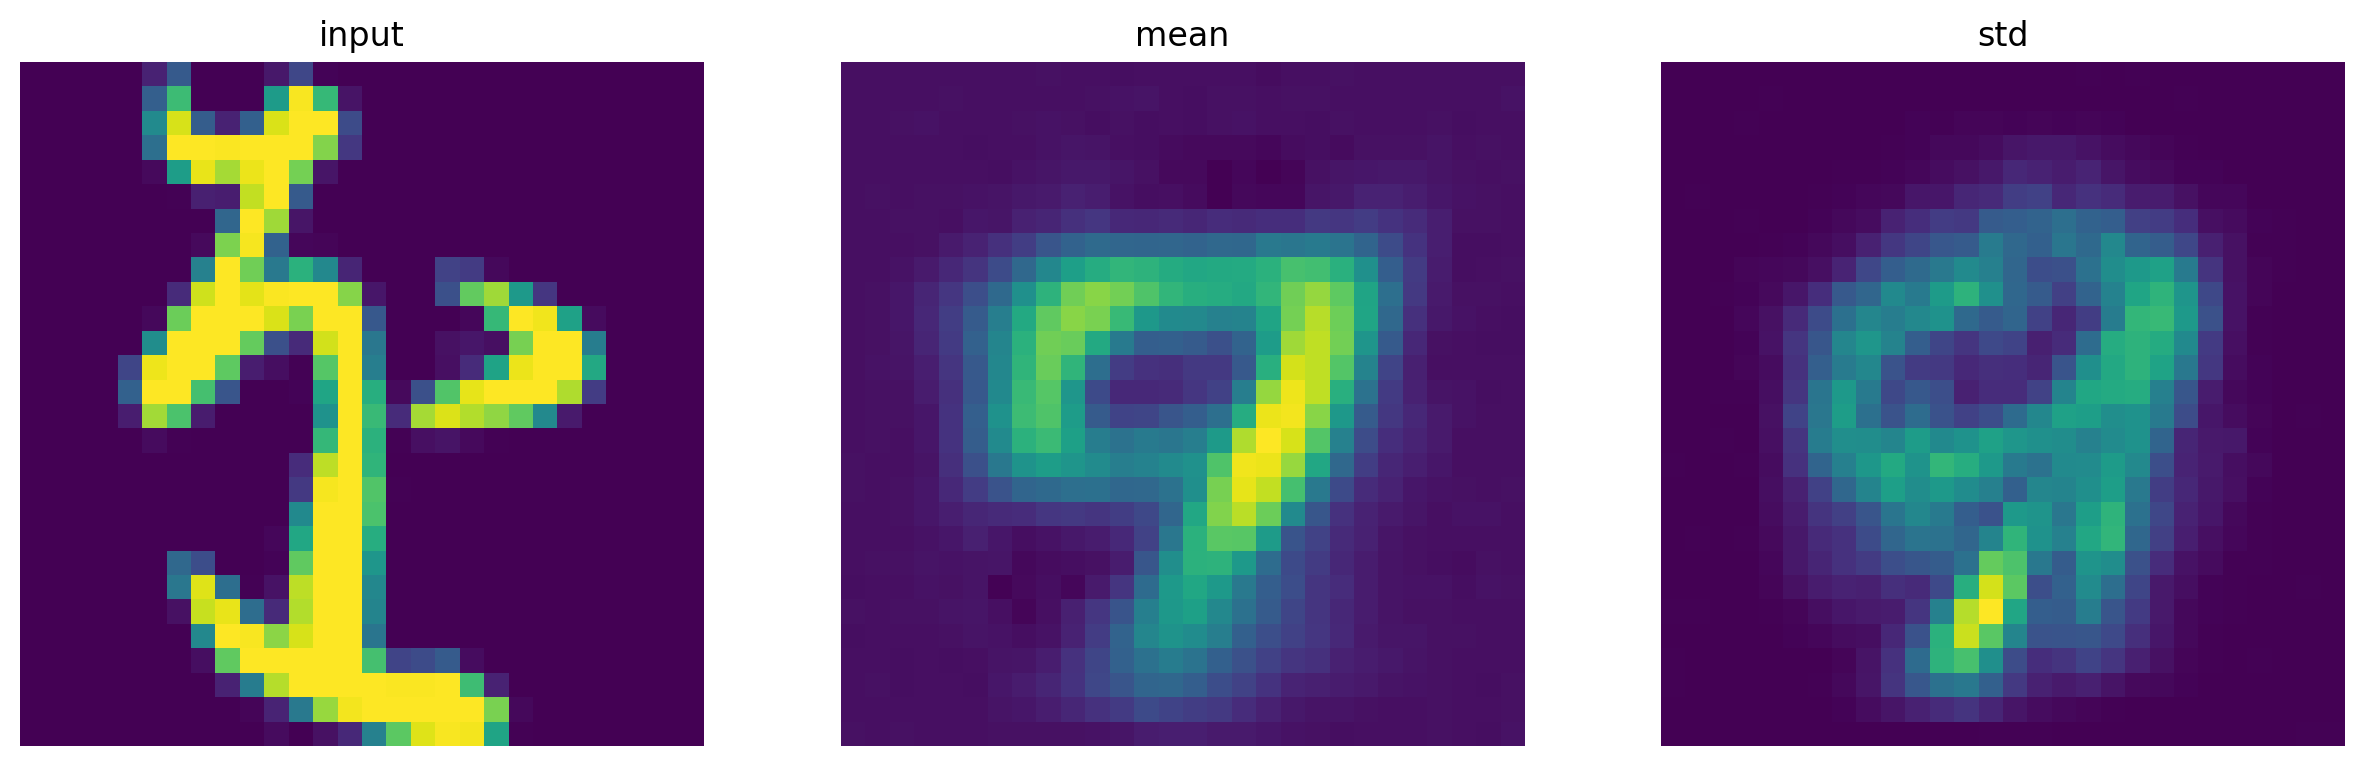

In [33]:
x = kmnist_sample[1,:,:,:]
iters = 50
dropout_p=0.1
decay=1e-6
l2 = 0.01

y_mean, y_std = uncertainity_estimate_2d(x, model, iters, l2=l2, dropout_p=dropout_p,decay=decay)

res_list = [x.cpu().view(28,28).numpy(), y_mean.view(28,28).numpy(), y_std.view(28,28).numpy()]
print(res_list[0].shape)
display_images(res_list, titles=['input','mean', 'std'], cols=len(res_list), interpolation=None, cmap="viridis")